# Deep learning models

### Todo



#### This cell is for defining various OPTIONS used for this notebook (working directory, how many rows and columns pandas displays for a dataframe, etc). 

#### Preferably this cell is also where we do important imports (for example pandas and numpy)

In [53]:
import os 
''' Input the directory where your folder created in main.processing.ipynb is located '''
#os.chdir('C:/Users/Trond/Documents/Master 2020/Processed data')
os.chdir('C:/Users/Briggstone/Documents/Master 2020/Processed data')
#os.chdir('C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data')

''' Where you want the output of this notebook to be placed '''
output_filepath = 'C:/Users/Briggstone/Documents/Master 2020/Processed data'
#output_filepath = 'C:/Users/MyPC/Documents/Andrijana/UiS/DATMAS Master oppgave/Processed data'

import numpy as np
import pandas as pd

# To get consistent results on functions which make us of np.random
np.random.seed(31415)

# Set ipython's max row display
pd.set_option('display.max_row', 1000)

# Set iPython's max column width to 50
pd.set_option('display.max_columns', 50)

# Which folder of preprocessed data we want to use
FOLDER_NAME = "Deep_Learning_Approach"


#### In this cell we define additional preprocessing functions specific for LSTM

In [54]:
from sklearn.model_selection import train_test_split

#Generator used to deliver batches of size 1
def create_generator_arrays(df):
    
    df_x = []
    df_y = []
    
    unique_subjects = df.PATNO.unique()  
    
    for u in unique_subjects:
        
        subject_data = df.loc[df.PATNO == u, :]
        
        y = subject_data.tail(1).HALL.values[0]
        y = np.expand_dims(y, axis = 0)
        df_y.append(y)
        
        subject_data.drop(["HALL", "PATNO"], axis = 1, inplace = True)
        
        x = subject_data.to_numpy()
        x = np.expand_dims(x, axis=0)
        df_x.append(x)
        
    return df_x,df_y



#Need to generate a validation set as we use this for early stopping and model validation for deep learning
#Generates a validation set of equal size to test set
def train_validation_test_split (train,test):
    
    num_of_unique_subjects_train = train.PATNO.unique().size  
    num_of_unique_subjects_test = test.PATNO.unique().size  
    total_unique_subjects = num_of_unique_subjects_train + num_of_unique_subjects_test
    
    train_ratio = num_of_unique_subjects_train / total_unique_subjects
    test_ratio = num_of_unique_subjects_test / total_unique_subjects
    
    #ratio to take from training set to make validation as large as test set
    
    validation_ratio = test_ratio / train_ratio
    
    tempdata = pd.DataFrame(train.PATNO.unique(), columns = ["PATNO"])

    HALL_EVER = []
    for id in train.PATNO.unique():

        if train.loc[(train.PATNO == id) & (train.HALL == 1), "HALL"].empty:
            HALL_EVER.append(0)
        else:
            HALL_EVER.append(1)

    Y = HALL_EVER
    X = tempdata

    temptrain, validation, _, _ = train_test_split( X, Y, test_size= validation_ratio, random_state= 1, stratify= Y, shuffle = True)

    temptrain = train.merge(temptrain, how = "inner", on = "PATNO")
    validation = train.merge(validation, how = "inner", on = "PATNO")
    
    train = temptrain
    
    return train,validation,test
    

#### In this cell we do additional preprocessing specific for LSTM

In [55]:
train = pd.read_csv(FOLDER_NAME + '/train.csv')
test = pd.read_csv(FOLDER_NAME + '/test.csv')
FP_DF = pd.read_csv(FOLDER_NAME + '/FP_DF.csv')

#Used for sensitivty vs year plot
test_PATNO = pd.DataFrame(test["PATNO"].unique(), columns = ["PATNO"])
test_FP = FP_DF.merge(test_PATNO, how = "inner", on = "PATNO")

# We don't implement samling for deep learning due to poor results on other algorithms
train.drop(["SAMPLING"], axis = 1, inplace  = True)

# We split into train,validation and test
train,validation,test = train_validation_test_split (train,test)

#Creating generators arrays
train_x, train_y = create_generator_arrays(train)
validation_x, validation_y = create_generator_arrays(validation)
test_x, test_y = create_generator_arrays(test)

#Getting values necessary for generators and lstm to work
num_of_dims = train.shape[1] - 2
num_of_unique_subjects_train = train.PATNO.unique().size  
num_of_unique_subjects_validation = validation.PATNO.unique().size
num_of_unique_subjects_test = test.PATNO.unique().size  

#Printing out data for number of subjects in each data set
print("Number of subjects train: ", num_of_unique_subjects_train)
print("Number of subjects validation: ", num_of_unique_subjects_validation)
print("Number of subjects test: ", num_of_unique_subjects_test)

C:\Users\Briggstone\AppData\Roaming\Python\Python37\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Number of subjects train:  239
Number of subjects validation:  80
Number of subjects test:  80


#### In this section we define helper functions for the LSTM implementation

In [56]:
from sklearn import metrics as met

def data_generator (x,y, num_of_epochs):
    for e in range(num_of_epochs):
        for i in range (len(x)):
            yield x[i], y[i]
            
def scorer_helper_function(y_true,y_pred,scorer_string):
    
    if scorer_string == "accuracy":
        return met.accuracy_score(y_true, y_pred)
    elif scorer_string == "precision":
        return met.precision_score(y_true,y_pred)
    elif scorer_string == "sensitivity":
        return met.recall_score(y_true,y_pred)
    elif scorer_string == "specificity":
        return met.recall_score(y_true,y_pred, pos_label = 0)
    elif scorer_string == "f1":
        return met.f1_score(y_true,y_pred)
    elif scorer_string == "roc_auc":
        return met.roc_auc_score(y_true,y_pred)
    elif scorer_string == "MCC":
        return met.matthews_corrcoef(y_true,y_pred)
        
        
def search_report (iteration_results, true_y, std = False):
    
    METRICS = {
        'accuracy': met.make_scorer(met.accuracy_score),
        'precision': met.make_scorer(met.precision_score),
        'sensitivity': met.make_scorer(met.recall_score),
        'specificity': met.make_scorer(met.recall_score,pos_label = 0),
        'f1': met.make_scorer(met.f1_score),
        'roc_auc': met.make_scorer(met.roc_auc_score),
        "MCC" : met.make_scorer(met.matthews_corrcoef)
    }
        
    columns = ["Hyperparameter Result"]
    for k,_ in METRICS.items():
        if std:
            columns.append(k + " std")
        else: 
            columns.append(k + " mean")
    
    
    df = pd.DataFrame(columns = columns)
    rows_list = []
    
    for hp, preds in iteration_results[0].items():
        results = { "Hyperparameter Result" : hp}
        predictions = []
        for iteration_result in iteration_results:
            predictions.append(iteration_result[hp])
                
        for k,_ in METRICS.items():
            metric_results = []
            for prediction in predictions:
                metric_results.append(scorer_helper_function(true_y, prediction, k))
                     
            if std:
                results[k + " std"] = np.std(metric_results)
            else:
                results[k + " mean"] = np.mean(metric_results)
            
        rows_list.append(results)
        
    results = df.append(pd.DataFrame(rows_list), sort = False)
            
    display(results.round(3)) 
    
    if not std:
        i = results["sensitivity mean"].argmax()
        display(results.iloc[i]["Hyperparameter Result"])
    
    
    
    
    
    

#### In this cell we set various parameters for our tuning and results

In [57]:
#How many grid searches are performed per hyperparameter search, used for more stable results
ITERATIONS_TUNING = 10

#HOW MANY EPOCHS ARE ALLOWED WITHOUT IMPROVEMENT
PATIENCE = 100



#Run tuning for layersize
RUN_LAYERSIZE_TUNING = 0
if RUN_LAYERSIZE_TUNING:
    LAYER_SIZES = [2,4,6,8,10,12]

# Run tuning for optimizer and learning rate
RUN_OPTILEARN_TUNING = 0
if RUN_OPTILEARN_TUNING:
    LAYER_SIZE = 6
    LEARNING_RATES = [0.001,0.01,0.1]

# Run look at potential overfitting
RUN_OVERFITTING_LOOK = 0
if RUN_OVERFITTING_LOOK:
    LAYER_SIZE = 6
    LEARNING_RATE = 0.1

# Run dropout layer tuning
RUN_DROPOUT_TUNING = 0
if RUN_DROPOUT_TUNING:
    LAYER_SIZE = 6
    LEARNING_RATE = 0.1
    DROPOUT_RATES = [0.0,0.1,0.2,0.3,0.4,0.5]

# Run number of layers tuning
RUN_LAYERS_TUNING = 0
if RUN_LAYERS_TUNING:
    LAYER_SIZE = 6
    LEARNING_RATE = 0.1
    DROPOUT_RATE = 0.0

# Get final results
RUN_FINAL_RESULTS = 0
if RUN_FINAL_RESULTS:
    LAYER_SIZE = 6
    LEARNING_RATE = 0.1
    DROPOUT_RATE = 0.0

#### In this cell we implement a simple LSTM with one layer and test different layer sizes

In [58]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics

import keras.optimizers as optimizers

if RUN_LAYERSIZE_TUNING:

    layer_sizes = LAYER_SIZES
    iteration_results = []

    for i in range (0,ITERATIONS_TUNING + 1):
        validation_predictions_layers = {}
        for layer_size in layer_sizes:

            model = Sequential (name = "LSTM")

            model.add(LSTM(layer_size, input_shape=(None, num_of_dims)))
            model.add(Dense(1, activation='sigmoid'))

            model.compile(optimizer='rmsprop',
                          loss='binary_crossentropy',
                          metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])

            from sklearn.utils import class_weight

            train_y_temp = [y.item() for y in train_y]

            class_weights = class_weight.compute_class_weight('balanced',
                                                             np.unique(train_y_temp),
                                                             train_y_temp)


            es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
            mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

            cb_list = [es,mc]

            epochs = 500

            model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                               validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

            model.load_weights('best_model.h5')

            predictions = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5

            validation_predictions_layers["Layer Size: " + str(layer_size)] = predictions

        iteration_results.append(validation_predictions_layers)

    search_report(iteration_results, validation_y)

#### In this cell we implement a simple LSTM with one layer and test optimizers and learning rates

In [59]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers

if RUN_OPTILEARN_TUNING:
    learning_rates = LEARNING_RATES
    optimizers = ["adam", "rmsprop", "sgd"]
    
    iteration_results = []

    for i in range (0,ITERATIONS_TUNING + 1):
        validation_predictions_opti_learn = {}
        for optimizer in optimizers:
            for learning_rate in learning_rates:

                model = Sequential (name = "LSTM")

                model.add(LSTM(LAYER_SIZE, input_shape=(None, num_of_dims)))
                model.add(Dense(1, activation='sigmoid'))

                if optimizer == "adam":
                    opt = keras.optimizers.Adam(learning_rate=learning_rate)
                elif optimizer == "rmsprop":
                    opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
                else:
                    opt = keras.optimizers.SGD(learning_rate=learning_rate)

                model.compile(optimizer=opt,
                              loss='binary_crossentropy',
                              metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


                from sklearn.utils import class_weight

                train_y_temp = [y.item() for y in train_y]

                class_weights = class_weight.compute_class_weight('balanced',
                                                                 np.unique(train_y_temp),
                                                                 train_y_temp)


                es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
                mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

                cb_list = [es,mc]

                epochs = 500

                model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                                   validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

                model.load_weights('best_model.h5')

                predictions = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5

                validation_predictions_opti_learn["Optimizer: " + optimizer + " and learning rate: " + str(learning_rate)] = predictions
                
            iteration_results.append(validation_predictions_opti_learn)

    search_report(iteration_results, validation_y)

#### We take a look at current model and see if it has an overfitting problem

In [60]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers

if RUN_OVERFITTING_LOOK:
    
    iteration_results_train = []
    iteration_results_validation = []

    for i in range (0,ITERATIONS_TUNING + 1):
        
        model = Sequential (name = "LSTM")

        model.add(LSTM(LAYER_SIZE, input_shape=(None, num_of_dims)))
        model.add(Dense(1, activation='sigmoid'))

        opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

        model.compile(optimizer=opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


        from sklearn.utils import class_weight

        train_y_temp = [y.item() for y in train_y]

        class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(train_y_temp),
                                                         train_y_temp)


        es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
        mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

        cb_list = [es,mc]

        epochs = 500

        model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                           validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

        model.load_weights('best_model.h5')

        predictions_train = model.predict_generator(data_generator(train_x, train_y, 1), steps = num_of_unique_subjects_train) > 0.5
        iteration_results_train.append({"training_results" : predictions_train})
        predictions_validation = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5
        iteration_results_validation.append({"validation_results" : predictions_validation})

    
    
    search_report(iteration_results_train, train_y)
    search_report(iteration_results_validation, validation_y)
        
        

#### We implement a dropout layer between the input-layer and the LSTM-layer test different dropout rates

In [61]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers

if RUN_DROPOUT_TUNING:
    
    iteration_results = []

    for i in range (0,ITERATIONS_TUNING + 1):

        validation_predictions_dropout = {}

        for dropout_rate in DROPOUT_RATES:

            model = Sequential (name = "LSTM")

            model.add(LSTM(LAYER_SIZE, dropout= dropout_rate, input_shape=(None, num_of_dims)))
            model.add(Dense(1, activation='sigmoid'))

            opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

            model.compile(optimizer=opt,
                          loss='binary_crossentropy',
                          metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


            from sklearn.utils import class_weight

            train_y_temp = [y.item() for y in train_y]

            class_weights = class_weight.compute_class_weight('balanced',
                                                             np.unique(train_y_temp),
                                                             train_y_temp)


            es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
            mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

            cb_list = [es,mc]

            epochs = 500

            model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                               validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

            model.load_weights('best_model.h5')

            predictions = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5

            validation_predictions_dropout["Dropout_rate: " + str(dropout_rate)] = predictions
            
        iteration_results.append(validation_predictions_dropout)

    search_report(iteration_results, validation_y)

#### Finally we try stacking additional LSTM-layers

In [62]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers

if RUN_LAYERS_TUNING:

    iteration_results = []

    for i in range (0,ITERATIONS_TUNING + 1):

        validation_predictions_layers = {}

        for layers in range(1,4):

            model = Sequential (name = "LSTM")

            if layers == 1:
                model.add(LSTM(LAYER_SIZE, dropout = DROPOUT_RATE, input_shape=(None, num_of_dims)))
                model.add(Dense(1, activation='sigmoid'))

            if layers == 2:
                model.add(LSTM(LAYER_SIZE, dropout = DROPOUT_RATE, return_sequences = True, input_shape=(None, num_of_dims)))
                model.add(LSTM(LAYER_SIZE))
                model.add(Dense(1, activation='sigmoid'))

            if layers == 3:
                model.add(LSTM(LAYER_SIZE, dropout = DROPOUT_RATE, return_sequences = True, input_shape=(None, num_of_dims)))
                model.add(LSTM(LAYER_SIZE, return_sequences = True))
                model.add(LSTM(LAYER_SIZE))
                model.add(Dense(1, activation='sigmoid'))

            opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

            model.compile(optimizer=opt,
                          loss='binary_crossentropy',
                          metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


            from sklearn.utils import class_weight

            train_y_temp = [y.item() for y in train_y]

            class_weights = class_weight.compute_class_weight('balanced',
                                                             np.unique(train_y_temp),
                                                             train_y_temp)


            es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
            mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

            cb_list = [es,mc]

            epochs = 500

            model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                               validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

            model.load_weights('best_model.h5')

            predictions = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5

            validation_predictions_layers["LSTM-Layers: " + str(layers)] = predictions
        
        iteration_results.append(validation_predictions_layers)

    search_report(iteration_results, validation_y)

### In this cell we look at final results

In [63]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers

if RUN_FINAL_RESULTS:

    iteration_results_train = []
    iteration_results_validation = []
    iteration_results_test = []

    for i in range (0,ITERATIONS_TUNING + 1):

        model = Sequential (name = "LSTM")

        model.add(LSTM(LAYER_SIZE, dropout = DROPOUT_RATE, input_shape=(None, num_of_dims)))
        model.add(Dense(1, activation='sigmoid'))

        opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

        model.compile(optimizer=opt,
                      loss='binary_crossentropy',
                      metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


        from sklearn.utils import class_weight

        train_y_temp = [y.item() for y in train_y]

        class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(train_y_temp),
                                                         train_y_temp)


        es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
        mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

        cb_list = [es,mc]

        epochs = 500

        model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                           validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

        model.load_weights('best_model.h5')

        predictions_train = model.predict_generator(data_generator(train_x, train_y, 1), steps = num_of_unique_subjects_train) > 0.5
        predictions_validation = model.predict_generator(data_generator(validation_x, validation_y, 1), steps = num_of_unique_subjects_validation) > 0.5      
        predictions_test = model.predict_generator(data_generator(test_x, test_y, 1), steps = num_of_unique_subjects_test) > 0.5     
        
        iteration_results_train.append({"Train results: " : predictions_train})
        iteration_results_validation.append({"Validation results: " : predictions_validation})
        iteration_results_test.append({"Test results: " : predictions_test})

    search_report(iteration_results_train, train_y)        
    search_report(iteration_results_train, train_y, std = True)
    search_report(iteration_results_validation, validation_y)  
    search_report(iteration_results_validation, validation_y, std = True)
    search_report(iteration_results_test, test_y)
    search_report(iteration_results_test, test_y, std = True)

### In this cell we define a function for plotting sensitivity vs year

In [64]:
import keras.metrics as met

def plot_sensitivity_by_year (FP_results):
    
    event_id_to_years = {
    "BL" : "Baseline",
    "V04": "1-Year",
    "V06": "2-Year",
    "V08": "3-Year",
    "V10": "4-Year",
    "V12": "5-Year",
    "V13": "6-Year",
    "V14": "7-Year",
    "V15": "8-Year"   
    }
        
    FP_ratio = {}
    FP_total = {}
        
    for event_id, year in event_id_to_years.items():
        
        correct = np.sum(FP_results.loc[FP_results.FP_EVENT_ID == event_id, "results"])
        total = FP_results.loc[FP_results.FP_EVENT_ID == event_id, "results"].size
        
        ratio = 0
        if total != 0:
            ratio = correct/total
            
        
        FP_ratio [year] = ratio
        FP_total [year] = total
   
    fig, axes = pyplot.subplots(nrows=1, ncols=2, figsize=(18, 5))
       
    x1, y1 = zip(*FP_ratio.items())
    axes[0].set_ylabel("Sensitivity")
    axes[0].set_xlabel("Year")
    axes[0].bar(x1,y1, color = 'g')
    
    x2, y2 = zip(*FP_total.items())
    axes[1].set_ylim (0,16)
    axes[1].set_ylabel("Positive Subjects")
    axes[1].set_xlabel("Year")
    axes[1].bar(x2,y2, color = 'm')
    
    fig.tight_layout()
    


### In this cell we plot sensitivity vs year, confusion matrix and roc curves for final model

,Hyperparameter Result,accuracy mean,precision mean,sensitivity mean,specificity mean,f1 mean,roc_auc mean,MCC mean
0,Test results:,0.662,0.385,0.476,0.729,0.426,0.603,0.193


'Test results: '

Sensitivity by year: Test


array([[43, 16],
       [11, 10]], dtype=int64)

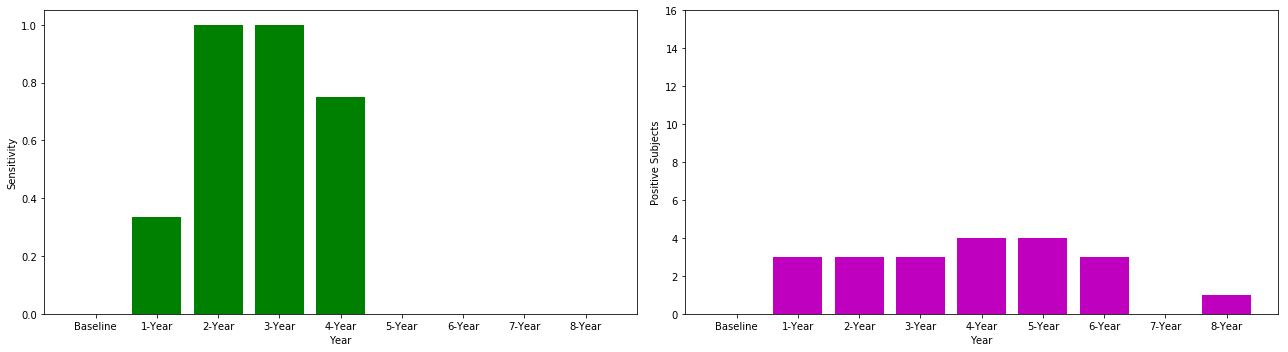

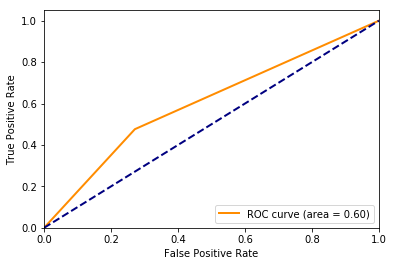

In [65]:
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Dropout

from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
import keras.metrics
import keras.optimizers as optimizers
from matplotlib import pyplot
import sklearn.metrics as met

if RUN_FINAL_RESULTS:
    LAYER_SIZE = 6
    LEARNING_RATE = 0.1
    DROPOUT_RATE = 0.0

    model = Sequential (name = "LSTM")

    model.add(LSTM(LAYER_SIZE, dropout = DROPOUT_RATE, input_shape=(None, num_of_dims)))
    model.add(Dense(1, activation='sigmoid'))

    opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=opt,
                  loss='binary_crossentropy',
                  metrics=['accuracy',keras.metrics.Recall(name = "sensitivity")])


    from sklearn.utils import class_weight

    train_y_temp = [y.item() for y in train_y]

    class_weights = class_weight.compute_class_weight('balanced',
                                                     np.unique(train_y_temp),
                                                     train_y_temp)


    es = EarlyStopping(monitor='val_sensitivity', mode = 'max', verbose = 0, patience = PATIENCE)
    mc = ModelCheckpoint('best_model.h5', monitor = 'val_sensitivity', mode = 'max', save_best_only = True, verbose = 0, save_weights_only= True)

    cb_list = [es,mc]

    epochs = 500

    model.fit_generator(data_generator(train_x,train_y, epochs), steps_per_epoch = num_of_unique_subjects_train, epochs = epochs, verbose = 0, class_weight=class_weights, \
                       validation_data = data_generator(validation_x,validation_y, epochs), validation_steps= num_of_unique_subjects_validation, callbacks = cb_list)

    model.load_weights('best_model.h5')

    predictions_test = model.predict_generator(data_generator(test_x, test_y, 1), steps = num_of_unique_subjects_test) > 0.5     
    iteration_results_test = [{"Test results: " : predictions_test}]

    search_report(iteration_results_test, test_y)

    temp_test_FP = test_FP.copy()
    temp_test_FP ['results'] = predictions_test
    print("Sensitivity by year: Test")        
    plot_sensitivity_by_year(temp_test_FP)

    display(met.confusion_matrix(test_y, predictions_test))

    fpr, tpr, tresholds = met.roc_curve (test_y, predictions_test)
    roc_auc = met.roc_auc_score(test_y,predictions_test)

    # Code inspired by https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    pyplot.figure()
    lw = 2
    pyplot.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    pyplot.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    pyplot.xlim([0.0, 1.0])
    pyplot.ylim([0.0, 1.05])
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend(loc="lower right")
    pyplot.show()

